# HW1: Logistic Regression

This class is about models and algorithms for discrete data. This homework will have all 3 ingredients:
* **Data**: the results from all college football games in the 2023 season
* **Model**: The *Bradely-Terry* model for predicting the winners of football game. The Bradley-Terry model is just logistic regression.
* **Algorithm**: We will implement two ways of fitting logistic regression: gradient descent and Newton's method

## The Bradley-Terry Model

In the Bradley-Terry Model, we give team $k$ a team-effect $\beta_k$. Basically, higher $\beta_k$ (relatively speaking), means that team $k$ is a better team.
The Bradley-Terry model formalizes this intution by modeling the log odds of team $k$ beating team $k'$ by the difference in their team effects, $\beta_k - \beta_{k'}$.

Let $i = 1,\ldots, n$ index games, and let $h(i) \in \{1,\ldots,K\}$ and $a(i) \in \{1,\ldots,K\}$ denote the indices of the home and away teams, respectively.
Let $Y_i \in \{0,1\}$ denote whether the home team won.
Under the Bradley-Terry model,
\begin{equation*}
  Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big),
\end{equation*}
where $\sigma(\cdot)$ is the sigmoid function. We can view this model as a logistic regression model with covariates $x_i \in \mathbb{R}^K$ where,
\begin{align*}
x_{i,k} &=
\begin{cases}
+1 &\text{if } h(i) = k \\
-1 &\text{if } a(i) = k \\
0 &\text{o.w.},
\end{cases}
\end{align*}
and parameters $\beta \in \mathbb{R}^K$.

## Data

We use the results of college football games in the fall 2023 season, which are available from the course github page and loaded for you below.

The data comes as a list of the outcomes of individual games. You'll need to wrangle the data to get it into a format that you can feed into the Bradley-Terry model.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
allgames = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/data/01_allgames.csv")

## Problem 0: Preprocessing

Preprocess the data to drop games with nan scores, construct the covariate matrix $X$, construct the response vector $y$, and do any other preprocessing you find useful.

In [3]:
allgames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599 entries, 0 to 3598
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  3599 non-null   int64  
 1   Season              3599 non-null   int64  
 2   Week                3599 non-null   int64  
 3   Season Type         3599 non-null   object 
 4   Start Date          3599 non-null   object 
 5   Start Time Tbd      3599 non-null   bool   
 6   Completed           3599 non-null   bool   
 7   Neutral Site        3599 non-null   bool   
 8   Conference Game     3599 non-null   bool   
 9   Attendance          851 non-null    float64
 10  Venue Id            3589 non-null   float64
 11  Venue               3589 non-null   object 
 12  Home Id             3599 non-null   int64  
 13  Home Team           3599 non-null   object 
 14  Home Conference     3576 non-null   object 
 15  Home Division       3576 non-null   object 
 16  Home P

In [33]:
# drop games with nan scores
# store the results in a new dataframe called df
df = allgames.dropna(subset=['Home Points', 'Away Points'])
# to avoid bias, drop all the games where the points are tied.
df = df[df["Away Points"] != df["Home Points"]]

# in Bradley-Terry model, constructing the response vector y
# the covariate matrix X is very sparse. we can one column for each team,
# and in each row, value equals 1 if the team is the home team, and equals -1 if the team is the away team,
# and equals 0 for all other teams.
# as the first step, no additional preprocessing is considered;
# they are left as improvement options later in this assignment.
points_difference = df["Home Points"] - df["Away Points"]
y = (points_difference > 0)*1 # consider the home team won if the home team had higher points in the game
teams = sorted(set(df["Away Team"]).union(set(df["Home Team"])))
X_df = pd.DataFrame(0, index=df.index, columns=teams)
for i, game in df.iterrows():
  home_team = game["Home Team"]
  away_team = game["Away Team"]
  X_df.loc[i, home_team] = 1
  X_df.loc[i, away_team] = -1
# convert into tensors
#type(y), type(X_df)
y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
X = torch.tensor(X_df.values, dtype=torch.float32)
y.shape, X.shape

(torch.Size([3574, 1]), torch.Size([3574, 703]))

## Problem 1: Loss function

Write a function to compute the loss, $L(\beta)$ defined be

\begin{equation*}
  L(\beta) = -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid x_i; \beta) + \frac{\gamma}{2} \| \beta \|_2^2
\end{equation*}
where $\gamma$ is a hyperparameter that controls the strength of your $\ell_2$ regularization.

You may want to use the `torch.distributions.Bernoulli` class.

In [34]:
# your code here
def compute_loss(beta, X, y, gamma):
  average_log_likelihood = torch.distributions.Bernoulli(probs = torch.sigmoid(X @ beta)).log_prob(y).mean()
  loss = -1 * average_log_likelihood + gamma / 2 * (torch.norm(beta, 2) ** 2) # add l2 regularization
  return loss

In [35]:
# unit testing
torch.manual_seed(0)
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma = 0.2
compute_loss(beta, X, y, gamma)

tensor(24.1480, grad_fn=<AddBackward0>)

In [36]:
compute_loss(beta, X, y, gamma).shape

torch.Size([])

## Problem 2: Gradient Descent

### Problem 2.1 Implementing and checking your gradients


Write a function to compute the gradient of the average negative log likelihood and check your output against the results obtained by PyTorch's automatic differentiation functionality.

The gradient is computed as:
$$
\nabla L(\beta) = -\frac{1}{n} \sum_{i=1}^{n} \left[(y_i - \sigma(\beta^\intercal x_i)) x_i\right] + \gamma \beta
$$

Note that this is a vector with the same shape as $\beta$.

In [37]:
# your code here
def compute_gradient(beta, X, y, gamma):
  grad_average_log_likelihood = -1/(y.shape[0]) * (X.T @ (y - torch.sigmoid(X @ beta)))
  grad_regularization = (gamma * beta)
  gradient = grad_average_log_likelihood + grad_regularization
  return gradient

In [38]:
loss = compute_loss(beta, X, y, gamma)
loss.backward()
auto_gradient = beta.grad

In [39]:
gradient = compute_gradient(beta, X, y, gamma)

In [40]:
torch.allclose(gradient, auto_gradient)

True

### Problem 2.2: Implement Gradient Descent


Now, use gradient descent to fit your Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements gradient descent to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curve of your algorithm and a brief discussion if it makes sense or not
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [41]:
# your code here (you can use multiple code and markdown cells to organize your answer)

In [42]:
# gradient descent implementation code

# parameters
torch.manual_seed(0)
learning_rate = 0.3
gamma = 0.2
# initial beta
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)

def gradient_descent_step(beta, learning_rate):
  #compute gradient
  current_gradient = compute_gradient(beta, X, y, gamma)
  next_beta = beta - learning_rate * current_gradient
  return next_beta

num_iterations = 100
list_of_loss_gradient_descent = [compute_loss(beta, X, y, gamma)]
for _ in range(num_iterations):
  new_beta = gradient_descent_step(beta, learning_rate)
  list_of_loss_gradient_descent.append(compute_loss(new_beta, X, y, gamma))
  if torch.allclose(beta, new_beta, atol=1e-4):
    break
  else:
    beta = new_beta

Text(0, 0.5, 'loss')

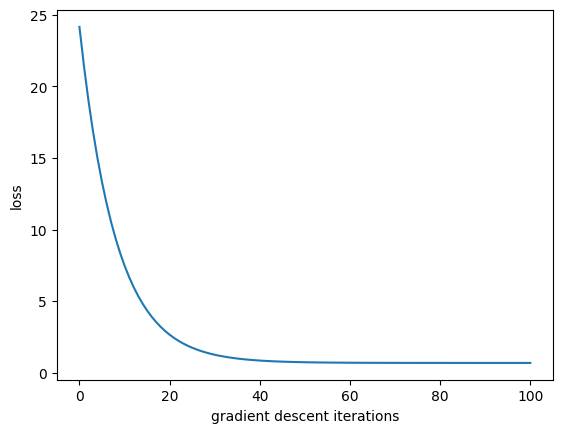

In [43]:
# plotting loss curve
loss_tensor_gradient_descent = torch.as_tensor(list_of_loss_gradient_descent)
plt.plot(loss_tensor_gradient_descent)
plt.xlabel("gradient descent iterations")
plt.ylabel("loss")

The above loss curve make sense - it is nicely shaped and the loss is going down and stablizing.

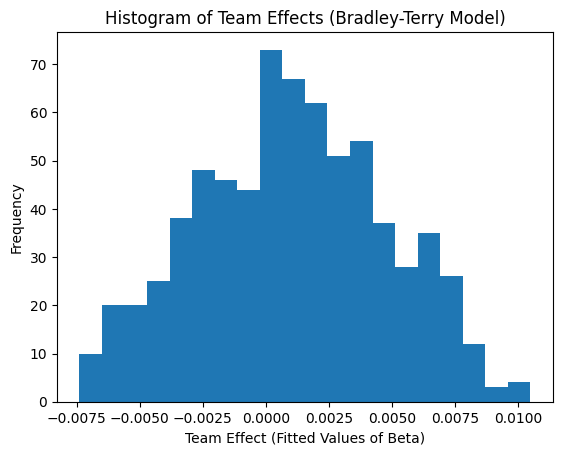

In [44]:
# plotting fitted values of beta
beta_df = pd.DataFrame({"Team": teams, "Effect": beta.detach().numpy().flatten()})

plt.hist(beta_df["Effect"], bins=20)
plt.title("Histogram of Team Effects (Bradley-Terry Model)")
plt.xlabel("Team Effect (Fitted Values of Beta)")
plt.ylabel("Frequency")
plt.show()

In [45]:
# top 10 teams
beta_df.sort_values(by="Effect", ascending=False).head(10)

,Team,Effect
307,Liberty,0.010481
353,Michigan,0.010460
643,Washington,0.010142
199,Florida State,0.010036
570,Texas,0.009528
518,South Dakota State,0.009257
5,Alabama,0.008957
17,Alma College,0.008580
130,Colorado Mines,0.008458
474,Randolph-Macon,0.008342


## Problem 3: Newton's Method

Now, use Newton's method to fit your Bradley-Terry model to the provided data.


### Problem 3.1 The Hessian



#### Problem 3.1.1. Implement and check the Hessian
Write a function to compute the Hessian of the average negative log likelihood and check your answer against the output of `from torch.autograd.functional.hessian`.

Recall that the gradient is computed as:
$$
\nabla L(\beta) = -\frac{1}{n} \sum_{i=1}^{n} \left[(y_i - \sigma(\beta^\intercal x_i)) x_i\right] + \gamma \beta
$$

Hence, the Hessian is computed as:
$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[\sigma'(\beta^\intercal x_i)x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)}
$$

Note that $\sigma'(a) = \sigma(a)(1-\sigma(a))$. Thus, the Hessian can be further simplified into:
$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[\sigma(\beta^\intercal x_i)(1-\sigma(\beta^\intercal x_i))x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)}
$$

Let $w_i:= \sigma(\beta^\intercal x_i)(1-\sigma(\beta^\intercal x_i))$. Observe that this is the variance in the GLM model. We can thus write:

$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[w_i x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)} = \frac{1}{n} X^\intercal WX + \gamma \mathbf{I}_{\dim (\beta)}
$$

where $W_{ii} = w_i$, a diagonal matrix.

In [46]:
# computing hessian
def compute_hessian(beta, X, y, gamma):
    y_hat = torch.sigmoid(X @ beta)
    W = torch.diag((y_hat * (1 - y_hat)).squeeze())
    hessian = (1 / y.shape[0]) * (X.T @ W @ X) + gamma * torch.eye(beta.shape[0])
    return hessian

In [47]:
# unit testing
torch.manual_seed(0)
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma = 0.2

In [48]:
H = compute_hessian(beta, X, y, gamma)
H.shape

torch.Size([703, 703])

In [49]:
loss_helper = lambda beta: compute_loss(beta, X, y, gamma)

auto_H = torch.autograd.functional.hessian(loss_helper, beta).squeeze()
auto_H.shape

torch.Size([703, 703])

In [50]:
print(torch.allclose(H, auto_H))

True


#### Problem 3.1.2: Positive definiteness

Compute the Hessian at the point $\beta = 0$ without regularization (set $\gamma = 0$). Unless you've done sort of pre-processing, it's probably singular.

In [51]:
# Hessian using the converged beta
print(torch.linalg.matrix_rank(H))

tensor(703)


In [52]:
# your code here
# Compute the Hessian at beta = 0 without regularization
beta_z = torch.zeros([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma_z = 0
H_z = compute_hessian(beta_z, X, y, gamma_z)
#check if H_z is singular
print("rank: ", torch.linalg.matrix_rank(H_z))
print("determinant:", torch.linalg.det(H_z))

rank:  tensor(699)
determinant: tensor(-0., grad_fn=<LinalgDetBackward0>)


In [53]:
H_z.shape

torch.Size([703, 703])

Note the two outputs above. As $699<703$, $H_z$ is not full rank, i.e., the Hessian computed at $\beta = 0$ without regularization is singular. The check also also be seen from $\det(H_z) = 0$.

#### Problem 3.1.3

Describe intuitively and mathematically what it means for the Hessian of the negative log likelihood to be singular in the context of this data and model

*your answer here*

**Answer 3.1.3**

Mathematically, Hessian of the negative log likelihood is singular means it is not full-rank, or equivalently, its determinant is zero.

#### Problem 3.1.4

Give a hypothesis for why the Hessian in this dataset and model is singular, and provide empirical evidence to support your hypothesis.

*your answer here*

**Answer 3.1.4**

Hypothesis: the Hessian of the negative log likelihood is singular is because the covariate matrix $X$ have linearly dependent columns, i.e., $X$ is not full column rank.

In [54]:
# your code here

# checking the rank of X
print("rank of X: ", torch.linalg.matrix_rank(X))

rank of X:  tensor(699)


As seen above, $X$ is indeed not full column rank.

#### Problem 3.1.5

Explain why the Hessian is invertible when $\gamma > 0$.

*your answer here*

**Answer 3.1.5**

Intuitively, this is GLM's analogy to the Ridge Regression model. In Ridge regression, by adding the regularization term $\gamma$, in the closed-form solution to the regression problem $(X^\intercal X + \gamma \mathbf{I})^{-1} X^\intercal y$, $X^\intercal X + \gamma \mathbf{I}$ is guaranteed to be invertible as the regularization part $\gamma \mathbf{I}$ forces the matrix to be full rank.

Mathematically, the analogy is also clear. Recall the definition of our computed Hessian:
$$
\nabla ^2 L(\beta) = \frac{1}{n} X^\intercal WX + \gamma \mathbf{I}_{\dim (\beta)}
$$
Whenever $\gamma >0$, the $\gamma \mathbf{I}_{\dim (\beta)}$ effectively forces the Hessian to be invertible by introducing regularization, making the Hessian full rank.

### Problem 3.2: Implement Newton's method

Now, use Newton's method to fit your $\ell_2$-regularized Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements Newton's method to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curves from Newton's method and from gradient descent, using the same regularization strength $\gamma$ and initialization $\beta_0$. Briefly discuss the results and compare their rates of convergence.
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [55]:
# your code here (you can use multiple code and markdown cells to organize your answer)
# gradient descent implementation code

# parameters
torch.manual_seed(0)
learning_rate = 0.3
gamma = 0.2
# initial beta
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)

def newton_step(beta, learning_rate):
  #compute gradient
  current_gradient = compute_gradient(beta, X, y, gamma)
  #compute hessian
  current_hessian = compute_hessian(beta, X, y, gamma)
  next_beta = beta - learning_rate * torch.linalg.inv(current_hessian) @ current_gradient
  return next_beta

num_iterations = 100
list_of_loss_newton = [compute_loss(beta, X, y, gamma)]
for _ in range(num_iterations):
  new_beta = newton_step(beta, learning_rate)
  list_of_loss_newton.append(compute_loss(new_beta, X, y, gamma))
  if torch.allclose(beta, new_beta, atol=1e-4):
    break
  else:
    beta = new_beta

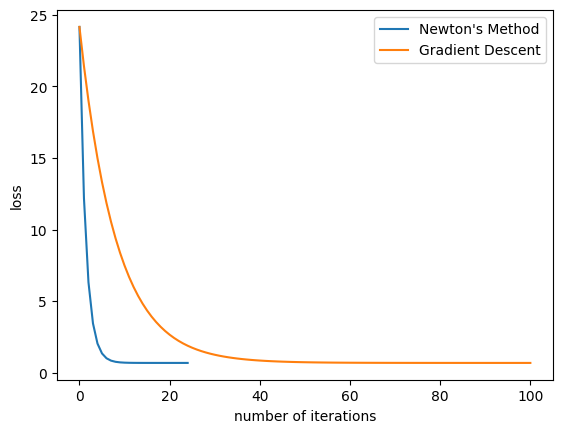

In [58]:
# plotting loss curve
list_of_loss_newton = torch.as_tensor(list_of_loss_newton)
plt.plot(list_of_loss_newton, label="Newton's Method")
plt.plot(loss_tensor_gradient_descent, label="Gradient Descent")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()

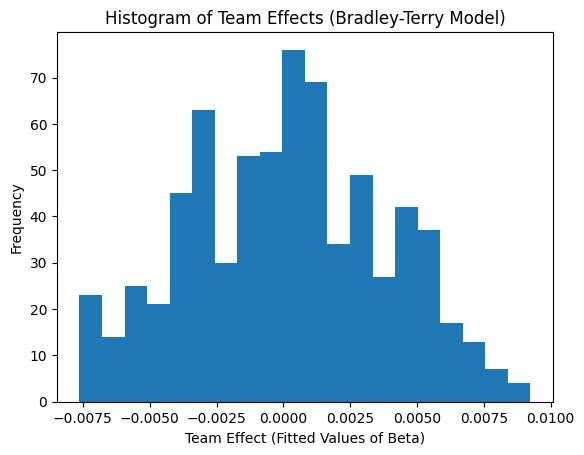

In [59]:
# plotting fitted values of beta
beta_df = pd.DataFrame({"Team": teams, "Effect": beta.detach().numpy().flatten()})

plt.hist(beta_df["Effect"], bins=20)
plt.title("Histogram of Team Effects (Bradley-Terry Model)")
plt.xlabel("Team Effect (Fitted Values of Beta)")
plt.ylabel("Frequency")
plt.show()

In [60]:
# top 10 teams
beta_df.sort_values(by="Effect", ascending=False).head(10)

,Team,Effect
353,Michigan,0.009242
307,Liberty,0.009241
643,Washington,0.009200
199,Florida State,0.009183
570,Texas,0.007916
518,South Dakota State,0.007885
5,Alabama,0.007840
130,Colorado Mines,0.007771
217,Georgia,0.007727
237,Harding,0.007700


## Problem 4: Model criticism and revision

Let's take another look the Bradley-Terry model from earlier and think about improvements we can make.


### Problem 4.1: Improvements to Bradley-Terry Model
Choose one way to improve the Bradley-Terry model. Discuss *a priori* why you think this change will improve the model and implement your change.

*your answer here*

**Answer 4.1**:

To improve analysis, there are multiple ways, including (1) re-investigating/refining model assumptions, (2) improve data quality, and (3) improve model architecture. I think the the model architecture is fairly robust, so the focus here in Q4 is on better understanding the data.  

In Q1 - Q3, I built the model without much knowledge of football. As seen from the results in previous parts, the ranking of the Bradley-Terry model is kind of strange as one would expect the team effect of South Dakota State would be way less than that of Alabama. This is because in Q1 - Q3, the design matrix $X$ is processed without sensible controls. The model only calculates the team effects based on the games played, however, *not all teams play with each other*. Upon some research, I realize there are divisions in college football, and divisions alone is very indicative of team effect (it is essentially a ranking of the teams). A team from `d1` may not play with any team in `d4`. However, in the previous implementation of the Bradley-Terry model, all teams are pooled together - if a team in `d4` is undefeated in their own division, it may even outrank a team in `d1`, which is not very sensible.

**Proposed Improvement:** run the Bradley-Terry model separately for each division.

**A priori discussion:**
- This would allow for more interpretable model outcomes.
- We may posit that the design matrix is more robust in estimating team effects in a sense that it contains less heterogeneity (we have stratified by division).

**Implementation:**
The code below creates separate design matrices and run the model using Newton's method.

In [ ]:
# Implementation 4.1


### Problem 4.2: Evaluation
Assess whether or not your change was an improvement or not. Provide empirical evidence by evaluating performance on a held out test set and include at least one plot supporting your assessment.

*your answer here*

### Problem 4.3: Reflection
Reflecting on the analysis we've conducted in this assignemnt, which conference is best? Is there a significant difference? Please justify your answer.

*your answer here*

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.